## Вычислительный эксперимент (базовый вариант)
### Предобработка данных

In [ ]:
# !pip install topicnet
# !pip install pymorphy3

In [2]:
import artm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set(style="darkgrid", palette="Set2")

from topicnet.dataset_manager import api

# topicnet imports
from topicnet.cooking_machine.cubes import (
    CubeCreator,
    GreedyStrategy,
    PerplexityStrategy,
    RegularizationControllerCube,
    RegularizersModifierCube,
)
from topicnet.cooking_machine.dataset import Dataset
from topicnet.cooking_machine.experiment import Experiment
from topicnet.cooking_machine.models import BaseScore
from topicnet.cooking_machine.models.topic_model import TopicModel
from topicnet.cooking_machine.model_constructor import add_standard_scores
from topicnet.cooking_machine.model_constructor import init_simple_default_model
from topicnet.cooking_machine.pretty_output import make_notebook_pretty
from topicnet.viewers.top_documents_viewer import TopDocumentsViewer
from topicnet.viewers.top_tokens_viewer import TopTokensViewer

from IPython.display import display, display_html

# for preprocessing
import nltk

from nltk.collocations import (
    BigramAssocMeasures,
    BigramCollocationFinder,
)
from nltk.corpus import (
    stopwords,
    wordnet,
)

nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.stem import WordNetLemmatizer

from pymorphy3 import MorphAnalyzer

from collections import Counter

from tqdm import tqdm

/opt/conda/lib/python3.7/site-packages/nltk/decorators.py:70: DeprecationWarning:

`formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly



[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


В качестве коллекции текстов используются [новости](https://www.kaggle.com/datasets/yutkin/corpus-of-russian-news-articles-from-lenta), опубликованные на сайте Lenta.ru до 2019-го года. Загружаем её.

In [2]:
df_lenta = pd.read_csv("lenta-ru-news.csv")
df_lenta

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning:



Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.




,url,title,text,topic,tags,date
0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,Первая мировая,1914/09/16
1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека,Первая мировая,1914/09/16
2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,Первая мировая,1914/09/17
3,https://lenta.ru/news/1914/09/17/bulldogn/,1914. Бульдог-гонец под Льежем,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека,Первая мировая,1914/09/17
4,https://lenta.ru/news/1914/09/18/zver/,1914. Под Люблином пойман швабский зверь,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека,Первая мировая,1914/09/18
...,...,...,...,...,...,...
800970,https://lenta.ru/news/2019/12/14/shnur/,Шнуров раскритиковал Гагарину на «Голосе»,Певец Сергей Шнуров раскритиковал свою коллегу...,NaN,ТВ и радио,2019/12/14
800971,https://lenta.ru/news/2019/12/14/dolg/,В России предложили изменить правила взыскания...,Министерство юстиции России предложило изменит...,NaN,Все,2019/12/14
800972,https://lenta.ru/news/2019/12/14/dark_euro/,В России назвали «черную дату» для Европы,Испытание США ранее запрещенной Договором о ли...,NaN,Политика,2019/12/14
800973,https://lenta.ru/news/2019/12/14/meteo/,Россиянам пообещали аномально теплую погоду,В ближайшие дни в европейской части России пог...,NaN,Общество,2019/12/14


Далее обработаем данные по дате публикации.

In [3]:
df_lenta.date = pd.to_datetime(df_lenta.date)
df_lenta.date

0        1914-09-16
1        1914-09-16
2        1914-09-17
3        1914-09-17
4        1914-09-18
            ...    
800970   2019-12-14
800971   2019-12-14
800972   2019-12-14
800973   2019-12-14
800974   2019-12-14
Name: date, Length: 800975, dtype: datetime64[ns]

Для базового эксперимента выделим небольшую часть из коллекции текстов. В данном случае эта часть будет соответствовать 1 кварталу 2002 года.

In [11]:
df_lenta_short = df_lenta[(df_lenta['date'].dt.year == 2002) & (df_lenta['date'].dt.quarter == 1)]
df_lenta_short

,url,title,text,topic,tags,date
41236,https://lenta.ru/news/2002/01/01/churches/,В Индонезии взорвали четыре церкви,Во вторник в столице индонезийской провинции Ц...,Россия,Все,2002-01-01
41237,https://lenta.ru/news/2002/01/01/donkey/,В Англии полиция прервала забег 30 ослов,Во вторник в Англии в графстве Суррей (Surrey)...,Из жизни,Все,2002-01-01
41238,https://lenta.ru/news/2002/01/01/cocktails/,Толпа басков атаковала банки и полицию,Во вторник утром в Испании в баскском городе Г...,Россия,Все,2002-01-01
41239,https://lenta.ru/news/2002/01/01/bomb/,Взрыв в Карачи: ранены девять человек,По крайней мере девять человек ранены в резуль...,Россия,Все,2002-01-01
41240,https://lenta.ru/news/2002/01/01/euro/,Маленький остров в Индийском океане первым пер...,В ночь на 1 января начинается наличное обращен...,Экономика,Все,2002-01-01
...,...,...,...,...,...,...
46723,https://lenta.ru/news/2002/03/31/grach/,Верховный Суд Украины опроверг сообщения СМИ о...,В субботу Верховный суд Украины опроверг распр...,Россия,Все,2002-03-31
46724,https://lenta.ru/news/2002/03/31/aeroflot/,"Из Москвы вылетел последний ""курящий"" рейс ""Аэ...","Авиакомпания ОАО ""Аэрофлот - Российские авиали...",Россия,Все,2002-03-31
46725,https://lenta.ru/news/2002/03/31/train/,В Испании столкнулись два пассажирских поезда,В субботу в Испании на выезде с вокзала города...,Мир,Все,2002-03-31
46726,https://lenta.ru/news/2002/03/31/time/,Россия перешла на летнее время: стрелки перево...,В ночь с субботы на воскресенье Россия перешла...,Россия,Все,2002-03-31


Оставляем нужные колонки.

In [14]:
df_lenta_raw = pd.DataFrame(df_lenta_short[['title',
                                            'text',
                                            'topic',
                                            'tags']]).rename(columns={'text': 'raw_text'})
df_lenta_raw

,title,raw_text,topic,tags
41236,В Индонезии взорвали четыре церкви,Во вторник в столице индонезийской провинции Ц...,Россия,Все
41237,В Англии полиция прервала забег 30 ослов,Во вторник в Англии в графстве Суррей (Surrey)...,Из жизни,Все
41238,Толпа басков атаковала банки и полицию,Во вторник утром в Испании в баскском городе Г...,Россия,Все
41239,Взрыв в Карачи: ранены девять человек,По крайней мере девять человек ранены в резуль...,Россия,Все
41240,Маленький остров в Индийском океане первым пер...,В ночь на 1 января начинается наличное обращен...,Экономика,Все
...,...,...,...,...
46723,Верховный Суд Украины опроверг сообщения СМИ о...,В субботу Верховный суд Украины опроверг распр...,Россия,Все
46724,"Из Москвы вылетел последний ""курящий"" рейс ""Аэ...","Авиакомпания ОАО ""Аэрофлот - Российские авиали...",Россия,Все
46725,В Испании столкнулись два пассажирских поезда,В субботу в Испании на выезде с вокзала города...,Мир,Все
46726,Россия перешла на летнее время: стрелки перево...,В ночь с субботы на воскресенье Россия перешла...,Россия,Все


Далее реализуем функции для предобработки данных, которые позволят преобразовать датасет в необходимый формат для TopicNet.

In [16]:
def vowpalize_sequence(sequence):
    '''
    Переводит последовательность в формат из Vowpal Wabbit.

    Аргумент:
    sequence - последовательность

    Возвращает:
    res - результат преобразования
    '''
    word_freq = Counter(sequence)
    del word_freq['']
    
    res = ''
    for word in word_freq:
        res += word + ":" + str(word_freq[word]) + ' '
  
    return res

def process_data(dataframe, vocab_size=16000):
    '''
    Отвечает за предобработку набора данных для
    дальнейшего использования в TopicNet.

    Аргумент:
    dataframe - данные, содержащие колонку raw_text
    vocab_size - размер словаря биграмм

    Результат:
    dataframe - предобработанные данные
    '''

    tokenized_text = []  # инициализируем список
    
    # разбиваем на токены
    for _, data in tqdm(dataframe.iterrows()):
        tokens = [token for token in nltk.wordpunct_tokenize(data.title.lower()) if len(token) > 1]
        tokens.extend([token for token in nltk.wordpunct_tokenize(data.raw_text.lower()) if len(token) > 1])
        tokenized_text.append(tokens)
    
    # запоминаем токенизацию
    dataframe['tokenized'] = tokenized_text

    # список стопслов
    stop = set(stopwords.words('russian'))

    # применяем лемматизацию, используем PyMorphy3
    lemmatized_text = []
    morph = MorphAnalyzer()
    
    # переводим в нормальную форму
    for text in tqdm(dataframe['tokenized'].values):
        lemmatized = [morph.parse(word)[0].normal_form for word in text]
        lemmatized = [word for word in lemmatized 
                      if word not in stop and word.isalpha()]
        lemmatized_text.append(lemmatized)
    
    dataframe['lemmatized'] = lemmatized_text

    # выбираем лучшие биграммы
    bigram_measures = BigramAssocMeasures()
    finder = BigramCollocationFinder.from_documents(dataframe['lemmatized'])
    finder.apply_freq_filter(5)
    set_dict = set(finder.nbest(bigram_measures.pmi, vocab_size))
    documents = dataframe['lemmatized']
    bigrams = []

    # добавляем биграммы
    for doc in tqdm(documents):
        entry = ['_'.join([word_first, word_second])
                 for word_first, word_second in zip(doc[:-1],doc[1:])
                 if (word_first, word_second) in set_dict]
        bigrams.append(entry)

    dataframe['bigram'] = bigrams
    
    # добавялем текст в формате из Vowpal Wabbit
    vw_text = []

    for index, data in tqdm(dataframe.iterrows()):
        vw_string = ''    
        doc_id = str(index)
        lemmatized = '@lemmatized ' + vowpalize_sequence(data.lemmatized)
        bigram = '@bigram ' + vowpalize_sequence(data.bigram)
        vw_string = ' |'.join([doc_id, lemmatized, bigram])
        vw_text.append(vw_string)

    dataframe['vw_text'] = vw_text

    return dataframe

Устанавливаем недостающие пакеты.

In [10]:
nltk.download('averaged_perceptron_tagger_ru')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger_ru to

[nltk_data]     /root/nltk_data...

[nltk_data]   Package averaged_perceptron_tagger_ru is already up-to-

[nltk_data]       date!

[nltk_data] Downloading package stopwords to /root/nltk_data...

[nltk_data]   Package stopwords is already up-to-date!


True

Обрабатываем данные.

In [17]:
df_lenta_vm = process_data(df_lenta_raw)
df_lenta_vm

5492it [00:01, 3262.15it/s]

100%|██████████| 5492/5492 [03:54<00:00, 23.41it/s]

100%|██████████| 5492/5492 [00:00<00:00, 20718.44it/s]

5492it [00:01, 4046.50it/s]


,title,raw_text,topic,tags,tokenized,lemmatized,bigram,vw_text
41236,В Индонезии взорвали четыре церкви,Во вторник в столице индонезийской провинции Ц...,Россия,Все,"[индонезии, взорвали, четыре, церкви, во, втор...","[индонезия, взорвать, четыре, церковь, вторник...","[взрывной_устройство, пока_удаться, всё_находи...",41236 |@lemmatized индонезия:1 взорвать:2 четы...
41237,В Англии полиция прервала забег 30 ослов,Во вторник в Англии в графстве Суррей (Surrey)...,Из жизни,Все,"[англии, полиция, прервала, забег, 30, ослов, ...","[англия, полиция, прервать, забег, осёл, вторн...",[полиция_найти],41237 |@lemmatized англия:2 полиция:2 прервать...
41238,Толпа басков атаковала банки и полицию,Во вторник утром в Испании в баскском городе Г...,Россия,Все,"[толпа, басков, атаковала, банки, полицию, во,...","[толпа, баск, атаковать, банк, полиция, вторни...","[вторник_утром, примерно_километр, прибыть_мес...",41238 |@lemmatized толпа:1 баск:1 атаковать:1 ...
41239,Взрыв в Карачи: ранены девять человек,По крайней мере девять человек ранены в резуль...,Россия,Все,"[взрыв, карачи, ранены, девять, человек, по, к...","[взрыв, карачи, ранить, девять, человек, крайн...","[девять_человек, крайний_мера, девять_человек,...",41239 |@lemmatized взрыв:2 карачи:3 ранить:2 д...
41240,Маленький остров в Индийском океане первым пер...,В ночь на 1 января начинается наличное обращен...,Экономика,Все,"[маленький, остров, индийском, океане, первым,...","[маленький, остров, индийский, океан, первый, ...","[ночь_январь, монета_евро, евро_сообщать, сооб...",41240 |@lemmatized маленький:2 остров:2 индийс...
...,...,...,...,...,...,...,...,...
46723,Верховный Суд Украины опроверг сообщения СМИ о...,В субботу Верховный суд Украины опроверг распр...,Россия,Все,"[верховный, суд, украины, опроверг, сообщения,...","[верховный, суд, украина, опровергнуть, сообще...","[верховный_суд, суд_украина, опровергнуть_сооб...",46723 |@lemmatized верховный:7 суд:11 украина:...
46724,"Из Москвы вылетел последний ""курящий"" рейс ""Аэ...","Авиакомпания ОАО ""Аэрофлот - Российские авиали...",Россия,Все,"[из, москвы, вылетел, последний, курящий, рейс...","[москва, вылететь, последний, курящий, рейс, а...","[рейс_аэрофлот, оао_аэрофлот, запрет_курение, ...",46724 |@lemmatized москва:2 вылететь:2 последн...
46725,В Испании столкнулись два пассажирских поезда,В субботу в Испании на выезде с вокзала города...,Мир,Все,"[испании, столкнулись, два, пассажирских, поез...","[испания, столкнуться, пассажирский, поезд, су...","[пассажирский_поезд, пассажирский_поезд, сообщ...",46725 |@lemmatized испания:2 столкнуться:2 пас...
46726,Россия перешла на летнее время: стрелки перево...,В ночь с субботы на воскресенье Россия перешла...,Россия,Все,"[россия, перешла, на, летнее, время, стрелки, ...","[россия, перейти, летний, время, стрелка, пере...","[летний_время, ночь_суббота, суббота_воскресен...",46726 |@lemmatized россия:3 перейти:2 летний:2...


Запишем обработанные данные в отдельный [файл](https://drive.google.com/file/d/1nhMbiBlH7Aeld4d6fDDo4eLS55SG_xg1/view?usp=sharing), который будет доступен на Google Drive вследствие довольно большого размера.

In [18]:
df_lenta_vm.reset_index().rename(columns={"index": "id"}).to_csv("lenta_2002_q1_preprocessed.csv")

Образуем датасет с помощью полученного файла.

In [4]:
lenta_data = Dataset("lenta_2002_q1_preprocessed.csv")

/opt/conda/lib/python3.7/site-packages/topicnet/cooking_machine/dataset.py:220: FutureWarning:

The error_bad_lines argument has been deprecated and will be removed in a future version.





На этот раз используем $50$ тем для тематических моделей. Зададим базовую модель.

In [5]:
TOTAL_TOPICS = 50

base_model = init_simple_default_model(
    dataset=lenta_data,
    modalities_to_use={'@lemmatized': 1.0, '@bigram': 0.75},
    main_modality='@lemmatized',
    specific_topics=TOTAL_TOPICS,
    background_topics=1,
)

Далее задаём регуляризатор, обучаем модель. К сожалению, симулировать случайность не получается (параметр `seed` постоянно равен -1, его изменение ни к чему не приводит пока, возможны проблемы).

In [7]:
base_model.scores

[PerplexityScore@all, SparsityThetaScore, SparsityPhiScore@lemmatized, PerplexityScore@lemmatized, TopicKernel@lemmatized, SparsityPhiScore@bigram, PerplexityScore@bigram, TopicKernel@bigram]

In [8]:
base_topic_model = TopicModel(base_model)
base_topics = [t for t in base_topic_model.topic_names if "background" not in t]

experiment_base = Experiment(
    experiment_id="experiment_start", 
    save_path="experiments", 
    topic_model=base_topic_model
)

base_cube = RegularizersModifierCube(
    num_iter=30,
    regularizer_parameters=[
        {
            'regularizer': artm.DecorrelatorPhiRegularizer(
                name='decorrelation_phi', 
                class_ids="@word", 
                topic_names=base_topics
            ),
            'tau_grid': [0, 0.25, 0.5, 0.75, 1]
        },
    ],
    verbose=True
)

base_cube(base_topic_model, lenta_data)


  0%|          | 0/5 [07:31<?, ?it/s]


[Model(id=--22h18m45s_14d03m2023y---, parent_id=-----------root-----------, experiment_id=experiment_start),
 Model(id=--22h20m10s_14d03m2023y---, parent_id=-----------root-----------, experiment_id=experiment_start),
 Model(id=--22h21m36s_14d03m2023y---, parent_id=-----------root-----------, experiment_id=experiment_start),
 Model(id=--22h23m01s_14d03m2023y---, parent_id=-----------root-----------, experiment_id=experiment_start),
 Model(id=--22h24m27s_14d03m2023y---, parent_id=-----------root-----------, experiment_id=experiment_start)]

Для примера выберем одну из моделей.

In [9]:
perplexity_criterion = 'PerplexityScore@lemmatized -> min COLLECT 1'
best_base_model = experiment_base.select(perplexity_criterion)

Смотрим разделение на темы. Предполагается, что пользователь исследует темы, ключевые слова и биграммы которых согласуются друг с другом, и из которых можно сложить целостную картину о новости.

In [10]:
base_model_top_tok = TopTokensViewer(best_base_model[0], num_top_tokens=5, method='phi')
base_model_html = base_model_top_tok.to_html()
base_model_top_doc = TopDocumentsViewer(best_base_model[0], dataset=lenta_data).view()

for topic_name, topic_docs in list(zip(best_base_model[0].topic_names, base_model_top_doc)):
    base_model_html = base_model_top_tok.to_html(topic_names=[topic_name])
    display_html(base_model_html, raw=True)
    display(topic_docs)

topic_0 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 главный_роль 
 0.021420 
 
 
 фильм_год 
 0.011620 
 
 
 гарри_поттер 
 0.011130 
 
 
 властелин_кольцо 
 0.010880 
 
 
 роль_фильм 
 0.010620 
 
 
 

 
 
 
   
   
 topic_0 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 фильм 
 0.038650 
 
 
 роль 
 0.012110 
 
 
 год 
 0.011740 
 
 
 хороший 
 0.010600 
 
 
 режиссёр 
 0.010200

'topic_0'

topic_1 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 золотой_медаль 
 0.034440 
 
 
 второе_место 
 0.028850 
 
 
 это_вид 
 0.021180 
 
 
 замкнуть_тройка 
 0.019790 
 
 
 тройка_призёр 
 0.019310 
 
 
 

 
 
 
   
   
 topic_1 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 место 
 0.017280 
 
 
 это 
 0.012690 
 
 
 завоевать 
 0.012440 
 
 
 медаль 
 0.012390 
 
 
 первый 
 0.012090

'topic_1'

topic_2 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 бин_ладен 
 0.043640 
 
 
 осама_бин 
 0.018410 
 
 
 михаил_жванецкий 
 0.009390 
 
 
 воинский_часть 
 0.009280 
 
 
 электронный_почта 
 0.008690 
 
 
 

 
 
 
   
   
 topic_2 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 ладен 
 0.009820 
 
 
 бин 
 0.009520 
 
 
 который 
 0.007870 
 
 
 жванецкий 
 0.007730 
 
 
 это 
 0.007730

'topic_2'

topic_3 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 associated_press 
 0.032150 
 
 
 сообщать_associated 
 0.028440 
 
 
 местный_время 
 0.014210 
 
 
 человек_погибнуть 
 0.013070 
 
 
 член_экипаж 
 0.009340 
 
 
 

 
 
 
   
   
 topic_3 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 самолёт 
 0.034240 
 
 
 аэропорт 
 0.015780 
 
 
 пассажир 
 0.015190 
 
 
 сообщать 
 0.012740 
 
 
 человек 
 0.011450

'topic_3'

topic_4 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 московский_область 
 0.017530 
 
 
 сергиевопосадский_омон 
 0.014040 
 
 
 гувд_московский 
 0.010990 
 
 
 генерал_майор 
 0.009820 
 
 
 ракета_носитель 
 0.009530 
 
 
 

 
 
 
   
   
 topic_4 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 ракета 
 0.019150 
 
 
 год 
 0.008900 
 
 
 суд 
 0.008520 
 
 
 спутник 
 0.007830 
 
 
 который 
 0.007580

'topic_4'

topic_5 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 миллион_доллар 
 0.106400 
 
 
 миллиард_доллар 
 0.064210 
 
 
 тысяча_доллар 
 0.033650 
 
 
 миллион_рубль 
 0.023850 
 
 
 около_миллион 
 0.016500 
 
 
 

 
 
 
   
   
 topic_5 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 доллар 
 0.066220 
 
 
 миллион 
 0.050440 
 
 
 год 
 0.030870 
 
 
 миллиард 
 0.020140 
 
 
 сумма 
 0.014710

'topic_5'

topic_6 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 процент_акция 
 0.032770 
 
 
 совет_директор 
 0.024850 
 
 
 миллион_доллар 
 0.020990 
 
 
 пакет_акция 
 0.015330 
 
 
 контрольный_пакет 
 0.011840 
 
 
 

 
 
 
   
   
 topic_6 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 акция 
 0.024790 
 
 
 компания 
 0.023730 
 
 
 год 
 0.010690 
 
 
 который 
 0.009490 
 
 
 это 
 0.009490

'topic_6'

topic_7 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 железный_дорога 
 0.023020 
 
 
 путь_сообщение 
 0.012620 
 
 
 заместитель_министр 
 0.010990 
 
 
 телескоп_hubble 
 0.010750 
 
 
 железнодорожный_транспорт 
 0.007940 
 
 
 

 
 
 
   
   
 topic_7 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.014330 
 
 
 космический 
 0.011500 
 
 
 который 
 0.011340 
 
 
 дорога 
 0.006440 
 
 
 сообщать 
 0.006110

'topic_7'

topic_8 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 лишение_свобода 
 0.031920 
 
 
 год_лишение 
 0.021810 
 
 
 верховный_суд 
 0.021470 
 
 
 признать_виновный 
 0.017930 
 
 
 тюремный_заключение 
 0.012660 
 
 
 

 
 
 
   
   
 topic_8 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.033160 
 
 
 суд 
 0.023550 
 
 
 приговорить 
 0.011190 
 
 
 свобода 
 0.011040 
 
 
 заключение 
 0.009000

'topic_8'

topic_9 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 премьер_министр 
 0.047700 
 
 
 михаил_касьянов 
 0.027570 
 
 
 панкисскома_ущелие 
 0.018880 
 
 
 риа_новость 
 0.014730 
 
 
 эдуард_шеварднадзе 
 0.009140 
 
 
 

 
 
 
   
   
 topic_9 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 министр 
 0.026420 
 
 
 грузия 
 0.021070 
 
 
 премьер 
 0.017140 
 
 
 россия 
 0.012890 
 
 
 касьянов 
 0.012130

'topic_9'

topic_10 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 совет_федерация 
 0.026570 
 
 
 риа_новость 
 0.021400 
 
 
 депутат_госдума 
 0.014160 
 
 
 государственный_дума 
 0.013200 
 
 
 нижний_палата 
 0.011590 
 
 
 

 
 
 
   
   
 topic_10 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 депутат 
 0.028060 
 
 
 госдума 
 0.022170 
 
 
 совет 
 0.013230 
 
 
 россия 
 0.012580 
 
 
 палата 
 0.011730

'topic_10'

topic_11 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 член_экипаж 
 0.014480 
 
 
 вертолёт_ми 
 0.013990 
 
 
 главное_управление 
 0.012440 
 
 
 мвд_россия 
 0.010050 
 
 
 генерал_лейтенант 
 0.009570 
 
 
 

 
 
 
   
   
 topic_11 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 вертолёт 
 0.023560 
 
 
 военный 
 0.013110 
 
 
 район 
 0.010790 
 
 
 мвд 
 0.010010 
 
 
 россия 
 0.009240

'topic_11'

topic_12 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 нью_йорк 
 0.051810 
 
 
 аль_каеда 
 0.032320 
 
 
 теракт_сентябрь 
 0.020670 
 
 
 бин_ладен 
 0.014670 
 
 
 торговый_центр 
 0.014440 
 
 
 

 
 
 
   
   
 topic_12 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 сша 
 0.019110 
 
 
 террорист 
 0.014730 
 
 
 американский 
 0.014370 
 
 
 нью 
 0.013880 
 
 
 сентябрь 
 0.013060

'topic_12'

topic_13 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 сообщать_bbc 
 0.062590 
 
 
 bbc_news 
 0.047140 
 
 
 сообщать_reuters 
 0.021650 
 
 
 возраст_год 
 0.007140 
 
 
 говориться_заявление 
 0.006060 
 
 
 

 
 
 
   
   
 topic_13 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 bbc 
 0.015330 
 
 
 сообщать 
 0.012070 
 
 
 который 
 0.011330 
 
 
 год 
 0.010670 
 
 
 news 
 0.010300

'topic_13'

topic_14 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 красноярский_край 
 0.024860 
 
 
 радио_свобода 
 0.013610 
 
 
 далай_лама 
 0.013250 
 
 
 год_рождение 
 0.011830 
 
 
 российский_моряк 
 0.011450 
 
 
 

 
 
 
   
   
 topic_14 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.010780 
 
 
 который 
 0.009930 
 
 
 город 
 0.008640 
 
 
 свобода 
 0.007650 
 
 
 край 
 0.006430

'topic_14'

topic_15 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 взрывной_устройство 
 0.026100 
 
 
 получить_ранение 
 0.021280 
 
 
 результат_взрыв 
 0.016350 
 
 
 погибнуть_человек 
 0.010590 
 
 
 взрыв_произойти 
 0.009250 
 
 
 

 
 
 
   
   
 topic_15 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 взрыв 
 0.024370 
 
 
 погибнуть 
 0.020700 
 
 
 человек 
 0.018330 
 
 
 произойти 
 0.014970 
 
 
 результат 
 0.012450

'topic_15'

topic_16 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 верховный_суд 
 0.021030 
 
 
 григорий_пасько 
 0.016420 
 
 
 четыре_год 
 0.012110 
 
 
 тихоокеанский_флот 
 0.009600 
 
 
 август_год 
 0.008050 
 
 
 

 
 
 
   
   
 topic_16 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.017940 
 
 
 суд 
 0.015550 
 
 
 военный 
 0.015510 
 
 
 пасько 
 0.012540 
 
 
 который 
 0.007620

'topic_16'

topic_17 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 юлия_тимошенко 
 0.014710 
 
 
 павел_бородин 
 0.009340 
 
 
 уголовный_дело 
 0.009100 
 
 
 суд_киев 
 0.008520 
 
 
 апелляционный_суд 
 0.008470 
 
 
 

 
 
 
   
   
 topic_17 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 который 
 0.010140 
 
 
 тимошенко 
 0.008740 
 
 
 суд 
 0.008330 
 
 
 это 
 0.007370 
 
 
 бородин 
 0.006530

'topic_17'

topic_18 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 цена_нефть 
 0.015010 
 
 
 миллиард_рубль 
 0.012530 
 
 
 сообщать_ак 
 0.010390 
 
 
 доллар_баррель 
 0.010170 
 
 
 баррель_сутки 
 0.009200 
 
 
 

 
 
 
   
   
 topic_18 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.017520 
 
 
 процент 
 0.014990 
 
 
 нефть 
 0.014010 
 
 
 доллар 
 0.011990 
 
 
 правительство 
 0.011620

'topic_18'

topic_19 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 владимир_путин 
 0.054060 
 
 
 президент_россия 
 0.049690 
 
 
 риа_новость 
 0.027870 
 
 
 россия_владимир 
 0.027310 
 
 
 это_заявить 
 0.021580 
 
 
 

 
 
 
   
   
 topic_19 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 путин 
 0.030590 
 
 
 россия 
 0.022820 
 
 
 президент 
 0.021840 
 
 
 владимир 
 0.015800 
 
 
 год 
 0.014520

'topic_19'

topic_20 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 вица_премьера 
 0.018010 
 
 
 time_warner 
 0.011260 
 
 
 федеральный_служба 
 0.010650 
 
 
 aol_time 
 0.010480 
 
 
 сибирский_язва 
 0.007860 
 
 
 

 
 
 
   
   
 topic_20 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 свой 
 0.010630 
 
 
 год 
 0.009970 
 
 
 который 
 0.009850 
 
 
 федеральный 
 0.006740 
 
 
 налоговый 
 0.006330

'topic_20'

topic_21 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 чемпионат_мир 
 0.022680 
 
 
 год_сообщать 
 0.016480 
 
 
 июнь_год 
 0.016020 
 
 
 сообщать_сайт 
 0.012960 
 
 
 сообщать_ввс 
 0.011090 
 
 
 

 
 
 
   
   
 topic_21 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.026890 
 
 
 который 
 0.015750 
 
 
 это 
 0.008440 
 
 
 свой 
 0.008110 
 
 
 сообщать 
 0.007890

'topic_21'

topic_22 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 los_angeles 
 0.022120 
 
 
 баскетбольный_ассоциация 
 0.015920 
 
 
 angeles_lakers 
 0.015350 
 
 
 национальный_баскетбольный 
 0.015350 
 
 
 basketball_association 
 0.014780 
 
 
 

 
 
 
   
   
 topic_22 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 который 
 0.013520 
 
 
 свой 
 0.011120 
 
 
 это 
 0.010620 
 
 
 команда 
 0.009510 
 
 
 весь 
 0.009350

'topic_22'

topic_23 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 северный_осетия 
 0.016370 
 
 
 президентский_выборы 
 0.013860 
 
 
 процент_голос 
 0.013350 
 
 
 принять_участие 
 0.009810 
 
 
 пост_президент 
 0.009590 
 
 
 

 
 
 
   
   
 topic_23 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 выборы 
 0.030510 
 
 
 президент 
 0.018240 
 
 
 республика 
 0.013960 
 
 
 голос 
 0.012830 
 
 
 процент 
 0.010850

'topic_23'

topic_24 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 российский_миротворец 
 0.018300 
 
 
 вооружённый_сила 
 0.009160 
 
 
 российский_федерация 
 0.008640 
 
 
 миротворческий_сила 
 0.008230 
 
 
 боевой_действие 
 0.008120 
 
 
 

 
 
 
   
   
 topic_24 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 российский 
 0.018920 
 
 
 абхазия 
 0.016990 
 
 
 россия 
 0.012130 
 
 
 миротворец 
 0.010580 
 
 
 грузия 
 0.009560

'topic_24'

topic_25 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 федеральный_сила 
 0.018050 
 
 
 северный_кавказ 
 0.016570 
 
 
 старый_атаг 
 0.013220 
 
 
 контртеррористический_операция 
 0.012080 
 
 
 глава_администрация 
 0.011590 
 
 
 

 
 
 
   
   
 topic_25 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 чечня 
 0.028970 
 
 
 чеченский 
 0.017980 
 
 
 боевик 
 0.015340 
 
 
 федеральный 
 0.011470 
 
 
 это 
 0.007260

'topic_25'

topic_26 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 составить_процент 
 0.014910 
 
 
 рабочий_место 
 0.012270 
 
 
 процентный_ставка 
 0.011120 
 
 
 экономика_сша 
 0.010960 
 
 
 прошлый_год 
 0.010480 
 
 
 

 
 
 
   
   
 topic_26 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 процент 
 0.045690 
 
 
 год 
 0.027120 
 
 
 рост 
 0.013820 
 
 
 это 
 0.013170 
 
 
 налог 
 0.011340

'topic_26'

topic_27 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 правоохранительный_орган 
 0.032810 
 
 
 уголовный_дело 
 0.019660 
 
 
 риа_новость 
 0.019010 
 
 
 настоящий_время 
 0.017630 
 
 
 возбудить_уголовный 
 0.016600 
 
 
 

 
 
 
   
   
 topic_27 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 преступник 
 0.016350 
 
 
 задержать 
 0.012000 
 
 
 москва 
 0.011050 
 
 
 сообщать 
 0.010990 
 
 
 дом 
 0.010710

'topic_27'

topic_28 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 сборная_россия 
 0.037190 
 
 
 хоккейный_лига 
 0.012930 
 
 
 национальный_хоккейный 
 0.011030 
 
 
 hockey_league 
 0.009890 
 
 
 national_hockey 
 0.009510 
 
 
 

 
 
 
   
   
 topic_28 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 сборная 
 0.018900 
 
 
 команда 
 0.017850 
 
 
 матч 
 0.015010 
 
 
 россия 
 0.012530 
 
 
 счёт 
 0.010850

'topic_28'

topic_29 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 госдепартамент_сша 
 0.012550 
 
 
 около_тысяча 
 0.012190 
 
 
 контрабанда_оружие 
 0.008660 
 
 
 учебный_заведение 
 0.008200 
 
 
 александр_тихонов 
 0.008160 
 
 
 

 
 
 
   
   
 topic_29 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 это 
 0.010660 
 
 
 сша 
 0.010630 
 
 
 который 
 0.010010 
 
 
 оружие 
 0.009270 
 
 
 виза 
 0.008440

'topic_29'

topic_30 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 уголовный_дело 
 0.050440 
 
 
 предъявить_обвинение 
 0.014930 
 
 
 риа_новость 
 0.013240 
 
 
 возбудить_уголовный 
 0.008810 
 
 
 процесс_дело 
 0.008340 
 
 
 

 
 
 
   
   
 topic_30 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 дело 
 0.041430 
 
 
 суд 
 0.026670 
 
 
 уголовный 
 0.016720 
 
 
 обвинение 
 0.015110 
 
 
 адвокат 
 0.012890

'topic_30'

topic_31 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 право_человек 
 0.017200 
 
 
 гаагский_трибунал 
 0.013900 
 
 
 слободан_милошевич 
 0.013770 
 
 
 бывший_президент 
 0.012330 
 
 
 президент_югославия 
 0.011300 
 
 
 

 
 
 
   
   
 topic_31 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 милошевич 
 0.013810 
 
 
 который 
 0.010790 
 
 
 свой 
 0.007760 
 
 
 страна 
 0.007620 
 
 
 право 
 0.007580

'topic_31'

topic_32 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 марат_сафин 
 0.020180 
 
 
 чемпионат_австралия 
 0.018250 
 
 
 открытый_чемпионат 
 0.017290 
 
 
 сообщать_ap 
 0.016620 
 
 
 российский_теннисист 
 0.014890 
 
 
 

 
 
 
   
   
 topic_32 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 турнир 
 0.017940 
 
 
 австралия 
 0.011370 
 
 
 который 
 0.010710 
 
 
 свой 
 0.010220 
 
 
 это 
 0.009910

'topic_32'

topic_33 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 арбитражный_суд 
 0.034810 
 
 
 судебный_пристав 
 0.021720 
 
 
 решение_суд 
 0.018470 
 
 
 ликвидация_тв 
 0.012100 
 
 
 высокий_арбитражный 
 0.010900 
 
 
 

 
 
 
   
   
 topic_33 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 суд 
 0.051470 
 
 
 решение 
 0.024650 
 
 
 тв 
 0.012820 
 
 
 судебный 
 0.012040 
 
 
 иск 
 0.011340

'topic_33'

topic_34 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 вица_президент 
 0.018160 
 
 
 пресс_релиз 
 0.011740 
 
 
 уголовный_дело 
 0.010760 
 
 
 яков_голдовский 
 0.009660 
 
 
 президент_компания 
 0.008710 
 
 
 

 
 
 
   
   
 topic_34 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 компания 
 0.020120 
 
 
 сибур 
 0.019350 
 
 
 газпром 
 0.017830 
 
 
 президент 
 0.013020 
 
 
 генпрокуратура 
 0.007330

'topic_34'

topic_35 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 палестинский_автономия 
 0.038080 
 
 
 ясир_арафат 
 0.036460 
 
 
 ариэль_шарон 
 0.020880 
 
 
 премьер_министр 
 0.018110 
 
 
 палестинский_лидер 
 0.014720 
 
 
 

 
 
 
   
   
 topic_35 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 арафат 
 0.033690 
 
 
 палестинский 
 0.029160 
 
 
 израиль 
 0.024990 
 
 
 шарон 
 0.017800 
 
 
 автономия 
 0.014240

'topic_35'

topic_36 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 эхо_москва 
 0.096080 
 
 
 радиостанция_эхо 
 0.024300 
 
 
 сообщать_эхо 
 0.019670 
 
 
 arthur_andersen 
 0.015720 
 
 
 аудиторский_компания 
 0.013050 
 
 
 

 
 
 
   
   
 topic_36 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 эхо 
 0.030600 
 
 
 компания 
 0.022620 
 
 
 москва 
 0.021160 
 
 
 enron 
 0.019970 
 
 
 радиостанция 
 0.014710

'topic_36'

topic_37 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 шестой_кнопка 
 0.017440 
 
 
 евгений_киселёв 
 0.011020 
 
 
 право_вещание 
 0.009880 
 
 
 шестой_канал 
 0.009300 
 
 
 участие_конкурс 
 0.009000 
 
 
 

 
 
 
   
   
 topic_37 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 тв 
 0.027430 
 
 
 конкурс 
 0.020790 
 
 
 канал 
 0.016670 
 
 
 шестой 
 0.015070 
 
 
 вещание 
 0.012480

'topic_37'

topic_38 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 борис_березовский 
 0.025870 
 
 
 либеральный_россия 
 0.017330 
 
 
 пресс_конференция 
 0.014720 
 
 
 москва_волгодонск 
 0.013000 
 
 
 жилой_дом 
 0.012750 
 
 
 

 
 
 
   
   
 topic_38 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 березовский 
 0.024510 
 
 
 россия 
 0.019560 
 
 
 это 
 0.013420 
 
 
 год 
 0.012160 
 
 
 фильм 
 0.011600

'topic_38'

topic_39 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 джордж_буш 
 0.042620 
 
 
 президент_сша 
 0.037710 
 
 
 белый_дом 
 0.023120 
 
 
 сша_джордж 
 0.015490 
 
 
 ядерный_оружие 
 0.013360 
 
 
 

 
 
 
   
   
 topic_39 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 сша 
 0.028760 
 
 
 буш 
 0.027770 
 
 
 президент 
 0.020640 
 
 
 ядерный 
 0.013430 
 
 
 джордж 
 0.010990

'topic_39'

topic_40 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 акция_протест 
 0.020160 
 
 
 папа_римский 
 0.016150 
 
 
 православный_церковь 
 0.016150 
 
 
 юрий_лужков 
 0.015630 
 
 
 русский_православный 
 0.014360 
 
 
 

 
 
 
   
   
 topic_40 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 церковь 
 0.014980 
 
 
 это 
 0.010930 
 
 
 москва 
 0.010860 
 
 
 акция 
 0.007510 
 
 
 православный 
 0.007490

'topic_40'

topic_41 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 рао_еэс 
 0.028600 
 
 
 еэс_россия 
 0.018520 
 
 
 риа_новость 
 0.015610 
 
 
 тысяча_рубль 
 0.013290 
 
 
 военный_служба 
 0.010560 
 
 
 

 
 
 
   
   
 topic_41 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.019570 
 
 
 россия 
 0.015170 
 
 
 это 
 0.013670 
 
 
 военный 
 0.010510 
 
 
 рао 
 0.009320

'topic_41'

topic_42 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 день_рождение 
 0.011390 
 
 
 большой_театр 
 0.010390 
 
 
 год_жизнь 
 0.009650 
 
 
 доменный_имя 
 0.008920 
 
 
 нобелевский_премия 
 0.008600 
 
 
 

 
 
 
   
   
 topic_42 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.012820 
 
 
 свой 
 0.011180 
 
 
 фильм 
 0.009760 
 
 
 который 
 0.009260 
 
 
 это 
 0.008080

'topic_42'

topic_43 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 квадратный_метр 
 0.019590 
 
 
 риа_новость 
 0.016400 
 
 
 пожарный_расчёт 
 0.010200 
 
 
 результат_пожар 
 0.009200 
 
 
 сообщать_риа 
 0.007820 
 
 
 

 
 
 
   
   
 topic_43 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 пожар 
 0.018050 
 
 
 музей 
 0.010350 
 
 
 год 
 0.010070 
 
 
 пожарный 
 0.009940 
 
 
 здание 
 0.008620

'topic_43'

topic_44 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 иностранный_дело 
 0.019980 
 
 
 министр_иностранный 
 0.014610 
 
 
 сергей_иванов 
 0.012860 
 
 
 министр_оборона 
 0.012030 
 
 
 северный_корея 
 0.010380 
 
 
 

 
 
 
   
   
 topic_44 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 россия 
 0.031150 
 
 
 сша 
 0.017170 
 
 
 российский 
 0.014660 
 
 
 страна 
 0.014050 
 
 
 министр 
 0.013120

'topic_44'

topic_45 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 саудовский_аравия 
 0.018400 
 
 
 совет_безопасность 
 0.014120 
 
 
 арабский_государство 
 0.013190 
 
 
 ближний_восток 
 0.011850 
 
 
 иностранный_дело 
 0.011150 
 
 
 

 
 
 
   
   
 topic_45 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 индия 
 0.012020 
 
 
 израиль 
 0.011560 
 
 
 пакистан 
 0.010440 
 
 
 заявить 
 0.010010 
 
 
 который 
 0.009780

'topic_45'

topic_46 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 сектор_газ 
 0.018280 
 
 
 ha_aretz 
 0.018100 
 
 
 израильский_военный 
 0.015790 
 
 
 израильский_армия 
 0.015090 
 
 
 западный_берег 
 0.014900 
 
 
 

 
 
 
   
   
 topic_46 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 израильский 
 0.032990 
 
 
 палестинский 
 0.021080 
 
 
 террорист 
 0.014410 
 
 
 палестинец 
 0.012730 
 
 
 сообщать 
 0.011380

'topic_46'

topic_47 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 санкт_петербург 
 0.051180 
 
 
 итар_тасс 
 0.022300 
 
 
 сообщать_ananova 
 0.017100 
 
 
 рубль_доллар 
 0.012370 
 
 
 тысяча_человек 
 0.011990 
 
 
 

 
 
 
   
   
 topic_47 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 петербург 
 0.015800 
 
 
 год 
 0.014390 
 
 
 санкт 
 0.011950 
 
 
 который 
 0.009050 
 
 
 человек 
 0.007900

'topic_47'

topic_48 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 кеннет_лэй 
 0.014490 
 
 
 михаэль_шумахер 
 0.012080 
 
 
 русский_служба 
 0.010260 
 
 
 давать_показание 
 0.010060 
 
 
 принять_участие 
 0.009630 
 
 
 

 
 
 
   
   
 topic_48 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 который 
 0.011350 
 
 
 свой 
 0.008250 
 
 
 команда 
 0.007890 
 
 
 сообщать 
 0.007230 
 
 
 enron 
 0.006920

'topic_48'

topic_49 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 риа_новость 
 0.160550 
 
 
 сообщать_риа 
 0.078480 
 
 
 пресс_служба 
 0.060560 
 
 
 сообщить_риа 
 0.053300 
 
 
 новость_пресс 
 0.020690 
 
 
 

 
 
 
   
   
 topic_49 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 риа 
 0.046120 
 
 
 новость 
 0.045070 
 
 
 служба 
 0.024610 
 
 
 сообщить 
 0.016920 
 
 
 пресс 
 0.016830

'topic_49'

background_50 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 солт_лейк 
 0.045730 
 
 
 лейк_сити 
 0.045300 
 
 
 олимпийский_игра 
 0.034730 
 
 
 олимпийский_комитет 
 0.024730 
 
 
 зимний_олимпийский 
 0.017000 
 
 
 

 
 
 
   
   
 background_50 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 олимпийский 
 0.026700 
 
 
 российский 
 0.019620 
 
 
 игра 
 0.016160 
 
 
 сити 
 0.013900 
 
 
 лейк 
 0.013650

'background_50'

- Релевантные: 0, 3, 5, 6, 8, 9, 10, 11, 12, 15, 16, 22, 23, 25, 26, 28, 29, 32, 34, 35, 36, 37, 38, 39, 40, 43, 44,
- Нерелевантные: 18, 19, 20, 21, 24, 27, 30, 31, 33, 45, 46
- Мусорные: 1, 2, 4, 7, 13, 14, 17, 41, 42, 47, 48, 49

Задаём новую модель.

In [11]:
new_model = init_simple_default_model(
    dataset=lenta_data,
    modalities_to_use={'@lemmatized': 1.0, '@bigram': 0.9},
    main_modality='@lemmatized',
    specific_topics=TOTAL_TOPICS,
    background_topics=1,
)

Задаём новые регуляризаторы, обучаем новую модель.

In [12]:
new_topic_model = TopicModel(new_model)
new_topics = [t for t in new_topic_model.topic_names if "background" not in t]

experiment_new = Experiment(
    experiment_id="experiment_new_models", 
    save_path="experiments", 
    topic_model=new_topic_model
)

new_cube = RegularizersModifierCube(
    num_iter=30,
    regularizer_parameters=[
        {
            'regularizer': artm.DecorrelatorPhiRegularizer(
                name='decorrelation_phi', 
                class_ids="@lemmatized", 
                topic_names=new_topics
            ),
            'tau_grid': [0, 1.5]
        },
        {
            'regularizer': artm.DecorrelatorPhiRegularizer(
                name='decorrelation_phi', 
                class_ids="@bigram", 
                topic_names=new_topics
            ),
            'tau_grid': [0, 1]
        },
        {
            'regularizer': artm.SmoothSparsePhiRegularizer(
                name="smsp_phi_topics_lemm",
                class_ids="@lemmatized", 
                topic_names=new_topics
            ),
            'tau_grid': [-0.05, 0, 0.05]
        },
        {
            'regularizer': artm.SmoothSparsePhiRegularizer(
                name="smsp_phi_topics_bigram",
                class_ids="@bigram", 
                topic_names=new_topics
            ),
            'tau_grid': [-0.05, 0, 0.05]
        },
    ],
    verbose=True
)

new_cube(new_topic_model, lenta_data)


  0%|          | 0/36 [1:02:08<?, ?it/s]


[Model(id=--22h31m06s_14d03m2023y---, parent_id=-----------root-----------, experiment_id=experiment_new_models),
 Model(id=--22h32m49s_14d03m2023y---, parent_id=-----------root-----------, experiment_id=experiment_new_models),
 Model(id=--22h34m31s_14d03m2023y---, parent_id=-----------root-----------, experiment_id=experiment_new_models),
 Model(id=--22h36m08s_14d03m2023y---, parent_id=-----------root-----------, experiment_id=experiment_new_models),
 Model(id=--22h37m50s_14d03m2023y---, parent_id=-----------root-----------, experiment_id=experiment_new_models),
 Model(id=--22h39m32s_14d03m2023y---, parent_id=-----------root-----------, experiment_id=experiment_new_models),
 Model(id=--22h41m06s_14d03m2023y---, parent_id=-----------root-----------, experiment_id=experiment_new_models),
 Model(id=--22h42m49s_14d03m2023y---, parent_id=-----------root-----------, experiment_id=experiment_new_models),
 Model(id=--22h44m27s_14d03m2023y---, parent_id=-----------root-----------, experiment_i

Выберем одну из моделей.

In [13]:
perplexity_criterion = 'PerplexityScore@lemmatized -> min COLLECT 1'
best_new_model = experiment_new.select(perplexity_criterion)

Смотрим на разделение по темам:

In [14]:
new_model_top_tok = TopTokensViewer(best_new_model[0], num_top_tokens=5, method='phi')
new_model_html = new_model_top_tok.to_html()
new_model_top_doc = TopDocumentsViewer(best_new_model[0], dataset=lenta_data).view()

for topic_name, topic_docs in list(zip(best_new_model[0].topic_names, new_model_top_doc)):
    new_model_html = new_model_top_tok.to_html(topic_names=[topic_name])
    display_html(new_model_html, raw=True)
    display(topic_docs)

topic_0 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 главный_роль 
 0.020890 
 
 
 фильм_год 
 0.010560 
 
 
 роль_фильм 
 0.010230 
 
 
 властелин_кольцо 
 0.009890 
 
 
 гарри_поттер 
 0.009550 
 
 
 

 
 
 
   
   
 topic_0 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 фильм 
 0.038400 
 
 
 год 
 0.012140 
 
 
 роль 
 0.011350 
 
 
 режиссёр 
 0.010120 
 
 
 хороший 
 0.009570

'topic_0'

topic_1 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 золотой_медаль 
 0.032870 
 
 
 второе_место 
 0.027340 
 
 
 это_вид 
 0.019930 
 
 
 замкнуть_тройка 
 0.018460 
 
 
 тройка_призёр 
 0.018010 
 
 
 

 
 
 
   
   
 topic_1 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 место 
 0.017100 
 
 
 это 
 0.012370 
 
 
 медаль 
 0.012150 
 
 
 первый 
 0.011970 
 
 
 завоевать 
 0.011920

'topic_1'

topic_2 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 российский_миротворец 
 0.016380 
 
 
 военный_округ 
 0.012360 
 
 
 воинский_часть 
 0.010830 
 
 
 михаил_жванецкий 
 0.008190 
 
 
 виктор_бут 
 0.007370 
 
 
 

 
 
 
   
   
 topic_2 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 военный 
 0.008760 
 
 
 миротворец 
 0.008560 
 
 
 это 
 0.007720 
 
 
 год 
 0.007710 
 
 
 российский 
 0.007530

'topic_2'

topic_3 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 associated_press 
 0.035150 
 
 
 сообщать_associated 
 0.031490 
 
 
 цена_нефть 
 0.015350 
 
 
 член_экипаж 
 0.011330 
 
 
 доллар_баррель 
 0.010380 
 
 
 

 
 
 
   
   
 topic_3 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 самолёт 
 0.040650 
 
 
 аэропорт 
 0.017460 
 
 
 пассажир 
 0.016650 
 
 
 сообщать 
 0.011420 
 
 
 нефть 
 0.011100

'topic_3'

topic_4 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 московский_область 
 0.016710 
 
 
 сергиевопосадский_омон 
 0.014420 
 
 
 гувд_московский 
 0.011330 
 
 
 генерал_майор 
 0.010770 
 
 
 баллистический_ракета 
 0.009370 
 
 
 

 
 
 
   
   
 topic_4 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 ракета 
 0.014240 
 
 
 суд 
 0.009760 
 
 
 год 
 0.008180 
 
 
 который 
 0.007590 
 
 
 омон 
 0.007430

'topic_4'

topic_5 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 миллион_доллар 
 0.119040 
 
 
 миллиард_доллар 
 0.043900 
 
 
 миллион_рубль 
 0.019520 
 
 
 около_миллион 
 0.017020 
 
 
 доллар_сша 
 0.014290 
 
 
 

 
 
 
   
   
 topic_5 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 доллар 
 0.054980 
 
 
 миллион 
 0.053570 
 
 
 год 
 0.029390 
 
 
 миллиард 
 0.013950 
 
 
 сумма 
 0.012420

'topic_5'

topic_6 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 арбитражный_суд 
 0.031990 
 
 
 процент_акция 
 0.024490 
 
 
 лукойл_гарант 
 0.014170 
 
 
 совет_директор 
 0.014000 
 
 
 ликвидация_тв 
 0.011770 
 
 
 

 
 
 
   
   
 topic_6 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 суд 
 0.027040 
 
 
 акция 
 0.016230 
 
 
 компания 
 0.015460 
 
 
 решение 
 0.013070 
 
 
 иск 
 0.011420

'topic_6'

topic_7 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 железный_дорога 
 0.019510 
 
 
 вица_премьер 
 0.016660 
 
 
 путь_сообщение 
 0.011540 
 
 
 телескоп_hubble 
 0.009830 
 
 
 заместитель_министр 
 0.009180 
 
 
 

 
 
 
   
   
 topic_7 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.015430 
 
 
 который 
 0.011680 
 
 
 украина 
 0.007200 
 
 
 дорога 
 0.005890 
 
 
 мпс 
 0.005670

'topic_7'

topic_8 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 лишение_свобода 
 0.030970 
 
 
 верховный_суд 
 0.021630 
 
 
 год_лишение 
 0.021300 
 
 
 признать_виновный 
 0.016550 
 
 
 тюремный_заключение 
 0.012520 
 
 
 

 
 
 
   
   
 topic_8 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.031350 
 
 
 суд 
 0.028130 
 
 
 приговорить 
 0.010640 
 
 
 свобода 
 0.010410 
 
 
 заключение 
 0.008760

'topic_8'

topic_9 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 премьер_министр 
 0.037040 
 
 
 михаил_касьянов 
 0.029990 
 
 
 риа_новость 
 0.017180 
 
 
 панкисскома_ущелие 
 0.016410 
 
 
 сообщать_риа 
 0.010880 
 
 
 

 
 
 
   
   
 topic_9 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 министр 
 0.024560 
 
 
 грузия 
 0.022020 
 
 
 россия 
 0.020760 
 
 
 премьер 
 0.015140 
 
 
 российский 
 0.013150

'topic_9'

topic_10 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 владимир_путин 
 0.028840 
 
 
 риа_новость 
 0.028080 
 
 
 президент_россия 
 0.023980 
 
 
 совет_федерация 
 0.023230 
 
 
 россия_владимир 
 0.012100 
 
 
 

 
 
 
   
   
 topic_10 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 депутат 
 0.019710 
 
 
 путин 
 0.019190 
 
 
 госдума 
 0.017730 
 
 
 россия 
 0.017210 
 
 
 президент 
 0.014380

'topic_10'

topic_11 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 вертолёт_ми 
 0.013070 
 
 
 федеральный_сила 
 0.012500 
 
 
 северный_кавказ 
 0.012250 
 
 
 мвд_россия 
 0.010860 
 
 
 объединить_группировка 
 0.010690 
 
 
 

 
 
 
   
   
 topic_11 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 вертолёт 
 0.022840 
 
 
 район 
 0.012080 
 
 
 военный 
 0.011610 
 
 
 мвд 
 0.010450 
 
 
 войско 
 0.010000

'topic_11'

topic_12 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 бин_ладен 
 0.040070 
 
 
 аль_каеда 
 0.035570 
 
 
 осама_бин 
 0.020970 
 
 
 нью_йорк 
 0.020350 
 
 
 теракт_сентябрь 
 0.020130 
 
 
 

 
 
 
   
   
 topic_12 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 сша 
 0.017360 
 
 
 террорист 
 0.016160 
 
 
 американский 
 0.013150 
 
 
 сентябрь 
 0.011470 
 
 
 теракт 
 0.011100

'topic_12'

topic_13 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 сообщать_bbc 
 0.063170 
 
 
 bbc_news 
 0.047670 
 
 
 сообщать_reuters 
 0.017080 
 
 
 корреспондент_lenta 
 0.008860 
 
 
 lenta_ru 
 0.008520 
 
 
 

 
 
 
   
   
 topic_13 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 bbc 
 0.015880 
 
 
 сообщать 
 0.012480 
 
 
 news 
 0.010860 
 
 
 который 
 0.010860 
 
 
 год 
 0.009400

'topic_13'

topic_14 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 красноярский_край 
 0.024210 
 
 
 радио_свобода 
 0.013680 
 
 
 российский_моряк 
 0.013300 
 
 
 год_рождение 
 0.012050 
 
 
 риа_новость 
 0.011920 
 
 
 

 
 
 
   
   
 topic_14 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 который 
 0.010170 
 
 
 год 
 0.009520 
 
 
 город 
 0.007980 
 
 
 свобода 
 0.007860 
 
 
 моряк 
 0.006060

'topic_14'

topic_15 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 взрывной_устройство 
 0.025610 
 
 
 получить_ранение 
 0.020930 
 
 
 человек_погибнуть 
 0.016950 
 
 
 результат_взрыв 
 0.015970 
 
 
 место_происшествие 
 0.013910 
 
 
 

 
 
 
   
   
 topic_15 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 погибнуть 
 0.023910 
 
 
 человек 
 0.023080 
 
 
 взрыв 
 0.022480 
 
 
 произойти 
 0.015990 
 
 
 результат 
 0.013560

'topic_15'

topic_16 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 верховный_суд 
 0.020580 
 
 
 григорий_пасько 
 0.015840 
 
 
 четыре_год 
 0.012530 
 
 
 тихоокеанский_флот 
 0.008060 
 
 
 лишение_свобода 
 0.007910 
 
 
 

 
 
 
   
   
 topic_16 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 суд 
 0.017420 
 
 
 год 
 0.015990 
 
 
 пасько 
 0.011890 
 
 
 военный 
 0.011310 
 
 
 который 
 0.009650

'topic_16'

topic_17 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 юлия_тимошенко 
 0.015260 
 
 
 павел_бородин 
 0.009710 
 
 
 суд_киев 
 0.009230 
 
 
 апелляционный_суд 
 0.008920 
 
 
 уголовный_дело 
 0.008210 
 
 
 

 
 
 
   
   
 topic_17 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 который 
 0.010530 
 
 
 тимошенко 
 0.008650 
 
 
 это 
 0.007550 
 
 
 суд 
 0.007540 
 
 
 бородин 
 0.006460

'topic_17'

topic_18 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 миллиард_доллар 
 0.028740 
 
 
 миллиард_рубль 
 0.023020 
 
 
 банк_россия 
 0.009550 
 
 
 курс_песо 
 0.007920 
 
 
 январь_год 
 0.007570 
 
 
 

 
 
 
   
   
 topic_18 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 доллар 
 0.018830 
 
 
 банк 
 0.017930 
 
 
 год 
 0.017610 
 
 
 процент 
 0.014210 
 
 
 миллиард 
 0.012890

'topic_18'

topic_19 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 это_заявить 
 0.017150 
 
 
 средство_массовый 
 0.016780 
 
 
 массовый_информация 
 0.016770 
 
 
 страна_ru 
 0.011460 
 
 
 риа_новость 
 0.010880 
 
 
 

 
 
 
   
   
 topic_19 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.015100 
 
 
 сайт 
 0.014420 
 
 
 интернет 
 0.014000 
 
 
 это 
 0.010000 
 
 
 россия 
 0.009250

'topic_19'

topic_20 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 вица_премьера 
 0.017850 
 
 
 time_warner 
 0.010780 
 
 
 aol_time 
 0.009730 
 
 
 министр_труд 
 0.007570 
 
 
 нью_джерси 
 0.007540 
 
 
 

 
 
 
   
   
 topic_20 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 который 
 0.011270 
 
 
 свой 
 0.009860 
 
 
 год 
 0.009220 
 
 
 компьютер 
 0.009210 
 
 
 microsoft 
 0.008400

'topic_20'

topic_21 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 чемпионат_мир 
 0.024080 
 
 
 год_сообщать 
 0.022890 
 
 
 сообщать_ввс 
 0.020070 
 
 
 сообщать_сайт 
 0.012270 
 
 
 июнь_год 
 0.011330 
 
 
 

 
 
 
   
   
 topic_21 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.026730 
 
 
 который 
 0.015740 
 
 
 это 
 0.008520 
 
 
 сообщать 
 0.008210 
 
 
 свой 
 0.007790

'topic_21'

topic_22 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 los_angeles 
 0.021820 
 
 
 баскетбольный_ассоциация 
 0.015830 
 
 
 angeles_lakers 
 0.015270 
 
 
 национальный_баскетбольный 
 0.015270 
 
 
 basketball_association 
 0.014700 
 
 
 

 
 
 
   
   
 topic_22 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 который 
 0.013340 
 
 
 это 
 0.010170 
 
 
 свой 
 0.010150 
 
 
 команда 
 0.009480 
 
 
 весь 
 0.009190

'topic_22'

topic_23 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 северный_осетия 
 0.016470 
 
 
 президентский_выборы 
 0.013840 
 
 
 процент_голос 
 0.013330 
 
 
 пост_президент 
 0.010060 
 
 
 принять_участие 
 0.009980 
 
 
 

 
 
 
   
   
 topic_23 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 выборы 
 0.029450 
 
 
 президент 
 0.018750 
 
 
 республика 
 0.015440 
 
 
 голос 
 0.012390 
 
 
 процент 
 0.011610

'topic_23'

topic_24 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 сообщать_the 
 0.032360 
 
 
 jerusalem_post 
 0.022350 
 
 
 the_jerusalem 
 0.019710 
 
 
 сообщать_интерфакс 
 0.010310 
 
 
 российский_федерация 
 0.008040 
 
 
 

 
 
 
   
   
 topic_24 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.011890 
 
 
 который 
 0.010480 
 
 
 сообщать 
 0.009500 
 
 
 россия 
 0.008150 
 
 
 the 
 0.007460

'topic_24'

topic_25 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 слободан_милошевич 
 0.015180 
 
 
 старый_атаг 
 0.012740 
 
 
 гаагский_трибунал 
 0.011910 
 
 
 бывший_президент 
 0.011700 
 
 
 федеральный_сила 
 0.011650 
 
 
 

 
 
 
   
   
 topic_25 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 чечня 
 0.020220 
 
 
 милошевич 
 0.015860 
 
 
 чеченский 
 0.013140 
 
 
 боевик 
 0.010790 
 
 
 президент 
 0.009520

'topic_25'

topic_26 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 составить_процент 
 0.014970 
 
 
 прошлый_год 
 0.014530 
 
 
 квартал_год 
 0.013120 
 
 
 вырасти_процент 
 0.012910 
 
 
 рабочий_место 
 0.012390 
 
 
 

 
 
 
   
   
 topic_26 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 процент 
 0.036510 
 
 
 год 
 0.029820 
 
 
 рост 
 0.016070 
 
 
 это 
 0.013190 
 
 
 налог 
 0.011170

'topic_26'

topic_27 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 правоохранительный_орган 
 0.041960 
 
 
 уголовный_дело 
 0.020160 
 
 
 риа_новость 
 0.019070 
 
 
 возбудить_уголовный 
 0.016490 
 
 
 настоящий_время 
 0.016160 
 
 
 

 
 
 
   
   
 topic_27 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 преступник 
 0.015750 
 
 
 задержать 
 0.011790 
 
 
 сообщать 
 0.010520 
 
 
 правоохранительный 
 0.010400 
 
 
 милиция 
 0.010230

'topic_27'

topic_28 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 сборная_россия 
 0.035760 
 
 
 хоккейный_лига 
 0.012440 
 
 
 национальный_хоккейный 
 0.010610 
 
 
 hockey_league 
 0.009510 
 
 
 это_сезон 
 0.009380 
 
 
 

 
 
 
   
   
 topic_28 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 команда 
 0.018900 
 
 
 сборная 
 0.018880 
 
 
 матч 
 0.015110 
 
 
 россия 
 0.012560 
 
 
 счёт 
 0.010870

'topic_28'

topic_29 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 нью_йорк 
 0.038750 
 
 
 около_тысяча 
 0.026700 
 
 
 торговый_центр 
 0.015880 
 
 
 госдепартамент_сша 
 0.012030 
 
 
 всемирный_торговый 
 0.011210 
 
 
 

 
 
 
   
   
 topic_29 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 сша 
 0.011360 
 
 
 который 
 0.011020 
 
 
 нью 
 0.010740 
 
 
 это 
 0.010230 
 
 
 йорк 
 0.008660

'topic_29'

topic_30 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 уголовный_дело 
 0.048140 
 
 
 предъявить_обвинение 
 0.014280 
 
 
 риа_новость 
 0.012700 
 
 
 ук_рф 
 0.007490 
 
 
 дело_отношение 
 0.007390 
 
 
 

 
 
 
   
   
 topic_30 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 дело 
 0.038850 
 
 
 суд 
 0.027590 
 
 
 уголовный 
 0.016040 
 
 
 обвинение 
 0.014020 
 
 
 адвокат 
 0.012330

'topic_30'

topic_31 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 право_человек 
 0.026440 
 
 
 счётный_палата 
 0.017190 
 
 
 смертный_казнь 
 0.008650 
 
 
 защита_право 
 0.007930 
 
 
 премьер_министр 
 0.007500 
 
 
 

 
 
 
   
   
 topic_31 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 который 
 0.010670 
 
 
 право 
 0.009660 
 
 
 страна 
 0.007940 
 
 
 год 
 0.007760 
 
 
 новый 
 0.007480

'topic_31'

topic_32 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 марат_сафин 
 0.019860 
 
 
 чемпионат_австралия 
 0.017970 
 
 
 открытый_чемпионат 
 0.017020 
 
 
 сообщать_ap 
 0.016980 
 
 
 российский_теннисист 
 0.014660 
 
 
 

 
 
 
   
   
 topic_32 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 турнир 
 0.017440 
 
 
 австралия 
 0.011220 
 
 
 который 
 0.010350 
 
 
 свой 
 0.010230 
 
 
 это 
 0.010060

'topic_32'

topic_33 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 пресс_служба 
 0.027150 
 
 
 судебный_пристав 
 0.023800 
 
 
 миллион_рубль 
 0.015320 
 
 
 процент_опросить 
 0.012910 
 
 
 населить_пункт 
 0.010440 
 
 
 

 
 
 
   
   
 topic_33 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 процент 
 0.016150 
 
 
 служба 
 0.008580 
 
 
 пресс 
 0.008240 
 
 
 это 
 0.008010 
 
 
 решение 
 0.007240

'topic_33'

topic_34 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 вица_президент 
 0.018110 
 
 
 уголовный_дело 
 0.012220 
 
 
 пресс_релиз 
 0.011790 
 
 
 яков_голдовский 
 0.010040 
 
 
 президент_компания 
 0.008940 
 
 
 

 
 
 
   
   
 topic_34 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 сибур 
 0.020080 
 
 
 компания 
 0.019950 
 
 
 газпром 
 0.018390 
 
 
 президент 
 0.012520 
 
 
 генпрокуратура 
 0.007590

'topic_34'

topic_35 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 палестинский_автономия 
 0.037900 
 
 
 ясир_арафат 
 0.035760 
 
 
 ариэль_шарон 
 0.018720 
 
 
 премьер_министр 
 0.018350 
 
 
 палестинский_лидер 
 0.015020 
 
 
 

 
 
 
   
   
 topic_35 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 арафат 
 0.033910 
 
 
 палестинский 
 0.028660 
 
 
 израиль 
 0.023500 
 
 
 шарон 
 0.017120 
 
 
 автономия 
 0.014300

'topic_35'

topic_36 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 эхо_москва 
 0.099420 
 
 
 радиостанция_эхо 
 0.024660 
 
 
 сообщать_эхо 
 0.020990 
 
 
 совет_директор 
 0.016340 
 
 
 газпром_медиа 
 0.015820 
 
 
 

 
 
 
   
   
 topic_36 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 эхо 
 0.030950 
 
 
 москва 
 0.022650 
 
 
 компания 
 0.020950 
 
 
 enron 
 0.017260 
 
 
 радиостанция 
 0.014360

'topic_36'

topic_37 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 евгений_киселёв 
 0.014800 
 
 
 северный_флот 
 0.010940 
 
 
 медиа_социум 
 0.010270 
 
 
 михаил_лесин 
 0.009340 
 
 
 шестой_телеканал 
 0.008750 
 
 
 

 
 
 
   
   
 topic_37 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 тв 
 0.025660 
 
 
 киселёв 
 0.011110 
 
 
 это 
 0.010510 
 
 
 курск 
 0.010090 
 
 
 вещание 
 0.009370

'topic_37'

topic_38 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 борис_березовский 
 0.025700 
 
 
 пресс_конференция 
 0.022080 
 
 
 депутат_госдума 
 0.021400 
 
 
 либеральный_россия 
 0.017460 
 
 
 жилой_дом 
 0.013690 
 
 
 

 
 
 
   
   
 topic_38 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 березовский 
 0.024410 
 
 
 россия 
 0.021500 
 
 
 это 
 0.013710 
 
 
 год 
 0.012290 
 
 
 фсб 
 0.011890

'topic_38'

topic_39 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 джордж_буш 
 0.042450 
 
 
 президент_сша 
 0.037240 
 
 
 белый_дом 
 0.022520 
 
 
 сша_джордж 
 0.015120 
 
 
 ядерный_оружие 
 0.013010 
 
 
 

 
 
 
   
   
 topic_39 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 сша 
 0.030450 
 
 
 буш 
 0.027860 
 
 
 президент 
 0.019920 
 
 
 американский 
 0.012580 
 
 
 ядерный 
 0.012370

'topic_39'

topic_40 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 акция_протест 
 0.019070 
 
 
 папа_римский 
 0.014740 
 
 
 православный_церковь 
 0.014740 
 
 
 тысяча_человек 
 0.014460 
 
 
 юрий_лужков 
 0.013330 
 
 
 

 
 
 
   
   
 topic_40 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 церковь 
 0.013380 
 
 
 это 
 0.009930 
 
 
 акция 
 0.009720 
 
 
 протест 
 0.007670 
 
 
 москва 
 0.007640

'topic_40'

topic_41 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 шестой_кнопка 
 0.025990 
 
 
 рао_еэс 
 0.018710 
 
 
 нтв_плюс 
 0.013390 
 
 
 олимпийский_комитет 
 0.012990 
 
 
 еэс_россия 
 0.011250 
 
 
 

 
 
 
   
   
 topic_41 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 конкурс 
 0.027370 
 
 
 канал 
 0.021500 
 
 
 шестой 
 0.016140 
 
 
 тв 
 0.016090 
 
 
 частота 
 0.010910

'topic_41'

topic_42 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 день_рождение 
 0.011550 
 
 
 большой_театр 
 0.009720 
 
 
 доменный_имя 
 0.009350 
 
 
 год_жизнь 
 0.008620 
 
 
 мировой_война 
 0.008470 
 
 
 

 
 
 
   
   
 topic_42 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.014620 
 
 
 свой 
 0.011460 
 
 
 который 
 0.009890 
 
 
 это 
 0.007680 
 
 
 режиссёр 
 0.006630

'topic_42'

topic_43 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 риа_новость 
 0.023140 
 
 
 квадратный_метр 
 0.019930 
 
 
 сообщать_риа 
 0.012000 
 
 
 пожарный_расчёт 
 0.010520 
 
 
 результат_пожар 
 0.009360 
 
 
 

 
 
 
   
   
 topic_43 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 пожар 
 0.019330 
 
 
 здание 
 0.011560 
 
 
 пожарный 
 0.011040 
 
 
 выставка 
 0.008950 
 
 
 музей 
 0.008930

'topic_43'

topic_44 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 иностранный_дело 
 0.020770 
 
 
 министр_иностранный 
 0.014620 
 
 
 сергей_иванов 
 0.013000 
 
 
 министр_оборона 
 0.012240 
 
 
 риа_новость 
 0.009560 
 
 
 

 
 
 
   
   
 topic_44 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 россия 
 0.033120 
 
 
 страна 
 0.015520 
 
 
 сша 
 0.014860 
 
 
 российский 
 0.014250 
 
 
 министр 
 0.012500

'topic_44'

topic_45 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 саудовский_аравия 
 0.017440 
 
 
 совет_безопасность 
 0.014690 
 
 
 арабский_государство 
 0.012780 
 
 
 ближний_восток 
 0.012350 
 
 
 иностранный_дело 
 0.011150 
 
 
 

 
 
 
   
   
 topic_45 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 израиль 
 0.014380 
 
 
 индия 
 0.011420 
 
 
 пакистан 
 0.010130 
 
 
 заявить 
 0.010040 
 
 
 который 
 0.009540

'topic_45'

topic_46 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 ha_aretz 
 0.019430 
 
 
 сектор_газ 
 0.019420 
 
 
 израильский_военный 
 0.017320 
 
 
 израильский_армия 
 0.016310 
 
 
 западный_берег 
 0.016150 
 
 
 

 
 
 
   
   
 topic_46 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 израильский 
 0.034980 
 
 
 палестинский 
 0.022690 
 
 
 террорист 
 0.014880 
 
 
 палестинец 
 0.013450 
 
 
 израиль 
 0.011810

'topic_46'

topic_47 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 санкт_петербург 
 0.045810 
 
 
 итар_тасс 
 0.016540 
 
 
 сообщать_ananova 
 0.014280 
 
 
 рубль_доллар 
 0.008530 
 
 
 официальный_курс 
 0.007690 
 
 
 

 
 
 
   
   
 topic_47 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 петербург 
 0.013980 
 
 
 год 
 0.013340 
 
 
 санкт 
 0.010040 
 
 
 который 
 0.008630 
 
 
 спутник 
 0.006510

'topic_47'

topic_48 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 тысяча_доллар 
 0.067990 
 
 
 конгресс_сша 
 0.012910 
 
 
 кеннет_лэй 
 0.012690 
 
 
 михаэль_шумахер 
 0.010050 
 
 
 компания_enron 
 0.008380 
 
 
 

 
 
 
   
   
 topic_48 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 который 
 0.011350 
 
 
 тысяча 
 0.010420 
 
 
 enron 
 0.009570 
 
 
 компания 
 0.008700 
 
 
 свой 
 0.008390

'topic_48'

topic_49 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 риа_новость 
 0.161190 
 
 
 сообщать_риа 
 0.075670 
 
 
 сообщить_риа 
 0.054410 
 
 
 пресс_служба 
 0.046340 
 
 
 новость_пресс 
 0.020830 
 
 
 

 
 
 
   
   
 topic_49 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 риа 
 0.046960 
 
 
 новость 
 0.045360 
 
 
 служба 
 0.018860 
 
 
 сообщить 
 0.014810 
 
 
 пресс 
 0.012850

'topic_49'

background_50 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 солт_лейк 
 0.047770 
 
 
 лейк_сити 
 0.047330 
 
 
 олимпийский_игра 
 0.036020 
 
 
 олимпийский_комитет 
 0.021730 
 
 
 зимний_олимпийский 
 0.017690 
 
 
 

 
 
 
   
   
 background_50 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 олимпийский 
 0.025800 
 
 
 российский 
 0.020160 
 
 
 игра 
 0.016630 
 
 
 сити 
 0.014200 
 
 
 лейк 
 0.014180

'background_50'

Изменения:

- Из мусорных в релевантные: 14, 41
- Остальных изменений нет.

Далее смотрим на перплексию.

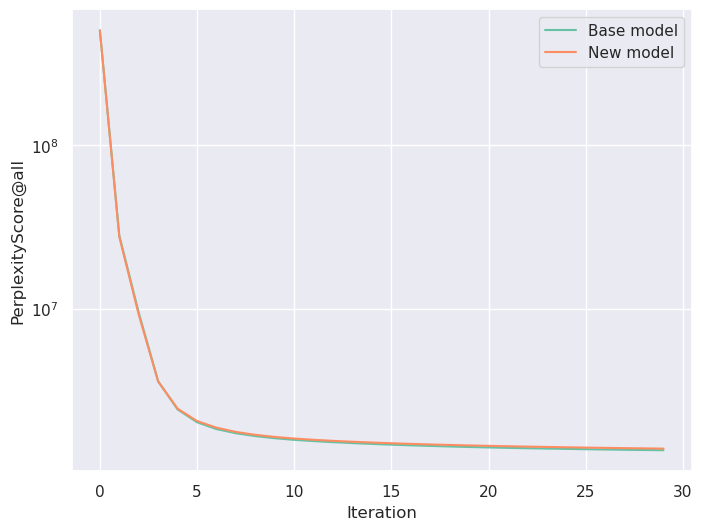

In [19]:
base_models = best_base_model
new_models = best_new_model

plt.figure(figsize=(8, 6))

plt.plot(np.arange(30),
         base_models[0].scores["PerplexityScore@all"],
         label='Base model')
plt.plot(np.arange(30),
         new_models[0].scores["PerplexityScore@all"],
         label='New model')
plt.xlabel('Iteration')
plt.ylabel('PerplexityScore@all')
plt.yscale('log')
plt.legend()
plt.show()

Кривая ведёт себя практически одинаково. Далее смотрим на разреженность матрицы $\Theta$.

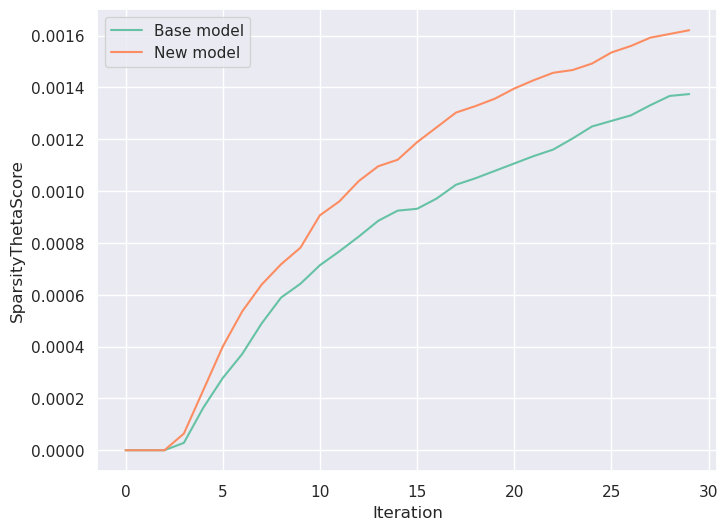

In [20]:
plt.figure(figsize=(8, 6))

plt.plot(np.arange(30),
         base_models[0].scores["SparsityThetaScore"],
         label='Base model')
plt.plot(np.arange(30),
         new_models[0].scores["SparsityThetaScore"],
         label='New model')
plt.xlabel('Iteration')
plt.ylabel('SparsityThetaScore')
plt.legend()
plt.show()

Матрица $\Theta$ стала более разреженной, чем в случае базовой модели, что позволяет лучше выделить темы.

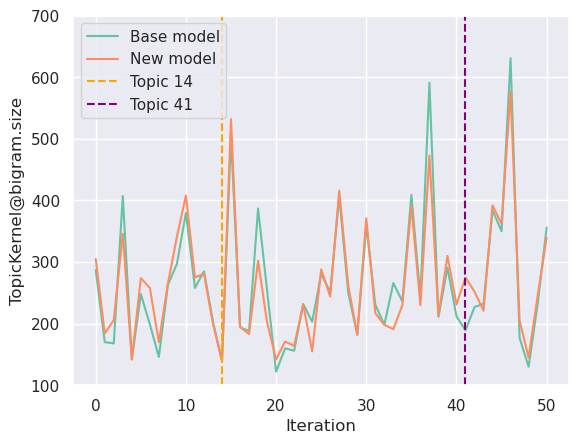

In [71]:
plt.plot(list(base_models[0].scores["TopicKernel@bigram.size"][-1].values()),
         label='Base model')
plt.plot(list(new_models[0].scores["TopicKernel@bigram.size"][-1].values()),
         label='New model')
plt.vlines(x=14, ymin=100, ymax=700, linestyles='dashed', label='Topic 14', color='orange')
plt.vlines(x=41, ymin=100, ymax=700, linestyles='dashed', label='Topic 41', color='purple')
plt.ylim(100, 700)
plt.xlabel('Iteration')
plt.ylabel('TopicKernel@bigram.size')
plt.legend()
plt.show()

Размер наибольшего ядра в новой модели меньше размера наибольшего ядра в базовой модели, в случае темы $41$ размер ядра увеличился, что повлияло в том числе и на состав темы.